# Preamble

## import

In [1]:
import os
import ipdb

import numpy as np
from scipy.linalg import block_diag

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib.synapses import Highpass, Lowpass

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='colorblind', style='whitegrid')
%matplotlib inline

import neuron

# Neuron Types

## Adaptive LIF

In [2]:
class AdaptiveLIFT(LIFRate):
    
    '''
    Aaron Voelker
    https://github.com/nengo/nengo/issues/1423
    '''
    
    probeable = ('spikes', 'voltage', 'refractory_time', 'threshold')

    min_voltage = NumberParam('min_voltage', high=0)
    tau_adapt = NumberParam('tau_adapt', low=0)
    inc_adapt = NumberParam('inc_adapt', low=0)

    def __init__(self, tau_rc=0.02, tau_ref=0.002, min_voltage=0,
                 amplitude=1, tau_adapt=0.1, inc_adapt=0.05):
        super(AdaptiveLIFT, self).__init__(
            tau_rc=tau_rc, tau_ref=tau_ref, amplitude=amplitude)
        self.min_voltage = min_voltage
        self.tau_adapt = tau_adapt
        self.inc_adapt = inc_adapt
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = np.zeros_like(gain)
        refractory_time = np.zeros_like(gain)
        threshold = np.ones_like(gain)

        return settled_firingrate(
            self.step_math, J, [voltage, refractory_time, threshold],
            dt=0.001, settle_time=0.3, sim_time=1.0)
    
    def gain_bias(self, max_rates, intercepts):
        return NeuronType.gain_bias(self, max_rates, intercepts)

    def max_rates_intercepts(self, gain, bias):
        return NeuronType.max_rates_intercepts(self, gain, bias)

    def step_math(self, dt, J, spiked, voltage, refractory_time, threshold):
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = (dt - refractory_time).clip(0, dt)

        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        voltage -= (J - voltage) * np.expm1(-delta_t / self.tau_rc)

        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage > threshold
        spiked[:] = spiked_mask * (self.amplitude / dt)

        # set v(0) = threshold and solve for t to compute the spike time
        # TODO: not sure if this mask is the right way to handle log domain errors
        threshold_spiked = threshold[spiked_mask]
        m = (voltage[spiked_mask] - threshold_spiked) / (J[spiked_mask] - threshold_spiked)
        t_spike = np.zeros_like(m)
        t_spike[m < 1] = dt + self.tau_rc * np.log1p(-m[m < 1])

        # update threshold using discretized lowpass filter
        # applied to the input 1 + spiked * inc_adapt 
        threshold -= ((1 + self.inc_adapt * spiked - threshold) *
                      np.expm1(-dt / self.tau_adapt))
        
        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage
        voltage[spiked_mask] = 0
        refractory_time[spiked_mask] = self.tau_ref + t_spike


@Builder.register(AdaptiveLIFT)
def build_alift(model, lif, neurons):
    model.sig[neurons]['voltage'] = Signal(
        np.zeros(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['refractory_time'] = Signal(
        np.zeros(neurons.size_in), name="%s.refractory_time" % neurons)
    model.sig[neurons]['threshold'] = Signal(
        np.ones(neurons.size_in), name="%s.threshold" % neurons)
    model.add_op(SimNeurons(
        neurons=lif,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['refractory_time'],
                model.sig[neurons]['threshold']]))

## Wilson Neuron

In [3]:
class WilsonRK4(NeuronType):

    probeable = ('spikes', 'voltage', 'recovery', 'conductance')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    _v0 = -0.754  # initial voltage
    _r0 = 0.279  # initial recovery
    _maxJ = 2.0  # clip input current at this maximum to avoid catastrophic shutdown
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonRK4, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
        # TODO(arvoelke): Try replacing this solver with something like
        # http://www2.gsu.edu/~matrhc/PyDSTool.htm
        # The main consideration is that we need a callback to count spikes
        from scipy.integrate import ode
        self.solver = ode(self._ode_fun).set_integrator(
            'dopri5', first_step=0.00005, nsteps=100,
            rtol=1e-2, atol=1e-3)  # runge-kutta method of order (4)5
        
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        J = self.current(x, gain, bias)
        voltage = self._v0*np.ones_like(J)
        recovery = self._r0*np.ones_like(J)
        conductance = np.zeros_like(J)

        return settled_firingrate(
            self.step_math, J, [voltage, recovery, conductance],
            dt=0.001, settle_time=0.1, sim_time=1.0)

    def _ode_fun(self, dummy_t, y, J):  # first argument to scipy.integrate.ode
        V, R, H = np.split(y, 3)
        dV = (-(17.81 + 47.58*V + 33.80*np.square(V))*(V - 0.48) -
              26*R*(V + 0.95) - 13*H*(V + 0.95) + J)
        dR = -R + 1.29*V + 0.79 + 3.30*np.square(V + 0.38)
        dH = -H + 11*(V + 0.754)*(V + 0.69)
        return np.concatenate((
            dV / self.tau_V, dR / self.tau_R, dH / self.tau_H))

    def step_math(self, dt, J, spiked, V, R, H):
        # It's a little silly to be reinitializing the solver on
        # every time-step, but any other ways that I could think of would 
        # violate the nengo builder's assumption that the neuron's state is
        # encapsulated by the signals in SimNeurons
        self.solver.set_initial_value(np.concatenate((V, R, H)))
        self.solver.set_f_params(J.clip(max=self._maxJ))
        
        spiked[:] = 0
        AP = V > self.threshold
        def spike_detector(dummy_t, y):  # callback for each sub-step
            V_t = y[:len(V)] > self.threshold
            spiked[:] += V_t & (~AP)  # note the "+="
            AP[:] = V_t
        self.solver.set_solout(spike_detector)

        V[:], R[:], H[:] = np.split(self.solver.integrate(self.solver.t + dt), 3)
        if not self.solver.successful():
            raise ValueError("ODE solver failed with status code: %d" % (
                self.solver.get_return_code()))
        spiked[:] /= dt

        return spiked, V, R, H


@Builder.register(WilsonRK4)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        neuron_type._v0*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        neuron_type._r0*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        np.zeros(neurons.size_in), name="%s.conductance" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
                model.sig[neurons]['recovery'],
                model.sig[neurons]['conductance']]))

## Durstewitz Neuron

In [31]:
class DurstewitzNeuron(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0, dt_neuron=0.025, DA=False):
        super(DurstewitzNeuron, self).__init__()
        self.v0 = v0
        self.dt_neuron = dt_neuron
        self.DA = DA
        neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
        neuron.h.load_file('stdrun.hoc')

    def gain_bias(self, max_rates, intercepts):
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
        J_steps = 100
        max_rate = max_rates.max()
        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1e-9  # test currents in amps
        for _ in range(10):
            J_test = np.linspace(-Jr, Jr, J_steps)
            rate = self.rates(J_test, np.ones(J_steps), np.zeros(J_steps))
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J_test[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J_test[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= np.sqrt(10)
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")
        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain
#         gain[:] = 1e-1 * (J_tops - J_threshold)
#         bias[:] = -8e0 * gain * intercepts
#         print('J_threshold, J_max', J_threshold, J_max)
#         print('gain', gain)
#         print('bias', bias)
        return gain, bias
    
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
#         print("Estimating firing rates in response to patch clamp...")
        J_test = self.current(x, gain, bias)
        n_neurons = gain.shape[0]
        spike_counts = np.zeros((n_neurons))
        settle_time = 0.1  # allow adaptive effects to kick in before recording spikes
        sim_time = 1.0
        dt = 0.001  # dt_nengo
        neuron.h.dt = self.dt_neuron
        neurons = []
        spk_vecs = []
        spk_recs = []
        soma_stims = []
        basal_stims = []
        prox_stims = []
        dist_stims = []
        for n in range(n_neurons):
            neurons.append(neuron.h.Durstewitz())
            # build morphology, but assume non-DA condition for calculating gain/bias
            neurons[n].init()
            spk_vecs.append(neuron.h.Vector())
            spk_recs.append(neuron.h.APCount(neurons[n].soma(0.5)))
            spk_recs[n].record(neuron.h.ref(spk_vecs[n]), dt*1000)
#             soma_stims.append(neuron.h.IClamp(neurons[n].soma(0.5)))
#             soma_stims[n].dur = (settle_time+sim_time)*1000
#             soma_stims[n].amp = J_test[n]*1e9
            basal_stims.append(neuron.h.IClamp(neurons[n].basal(0.5)))
            basal_stims[n].dur = (settle_time+sim_time)*1000
            basal_stims[n].amp = J_test[n]*1e9  # convert amps to nanoamps
            prox_stims.append(neuron.h.IClamp(neurons[n].prox(0.5)))
            prox_stims[n].dur = (settle_time+sim_time)*1000
            prox_stims[n].amp = J_test[n]*1e9  # convert amps to nanoamps
            dist_stims.append(neuron.h.IClamp(neurons[n].dist(0.5)))
            dist_stims[n].dur = (settle_time+sim_time)*1000
            dist_stims[n].amp = J_test[n]*1e9  # convert amps to nanoamps
        neuron.h.tstop = (settle_time+sim_time)*1000
        neuron.h.run()
        spike_counts = [np.where(np.array(sts) > settle_time*1000)[0].shape[0] for sts in spk_vecs]
        for n in range(n_neurons):
            spk_vecs[n].play_remove()
            del(neurons[0])
#         print('J', J_test)
#         print('Firing Rate', np.array(spike_counts)/sim_time)
        return np.array(spike_counts)/sim_time
    
    def step_math(self, J, stims, v_recs, spk_vecs, spk_recs, spk_before, voltage, spiked, time, dt):
        n_neurons = J.shape[0]
#         spk_before = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        for n in range(n_neurons):
            for stim in stims:
                stim[n].amp = J[n]*1e9
        if neuron.h.t < (time - dt)*1000:  # Nengo starts at t=dt
            neuron.h.tstop = time*1000
            neuron.h.continuerun(neuron.h.tstop)
        voltage[:] = np.array([v[-1] for v in v_recs]).clip(-100, 60)
        spk_after = [list(spk_vecs[n]) for n in range(n_neurons)]
        for n in range(n_neurons):
            spiked[n] = (len(spk_after[n]) - len(spk_before[n])) / dt
            spk_before[n] = list(spk_after[n])
        

class SimNeuronNeurons(Operator):
    def __init__(self, neuron_type, neurons, J, output, states, dt):
        super(SimNeuronNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = neurons
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
#         self.t_recs = []
        self.v_recs = []
        self.spk_vecs = []
        self.spk_recs = []
        self.spk_before = [[] for n in range(len(neurons))]
        self.soma_stims = []
        self.basal_stims = []
        self.prox_stims = []
        self.dist_stims = []
        for n in range(len(neurons)):
            if self.neuron_type.DA:
                self.neurons[n].init_DA()
            else:
                self.neurons[n].init()
#             self.t_recs.append(neuron.h.Vector())
#             self.t_recs[n].record(neuron.h._ref_t)
            self.v_recs.append(neuron.h.Vector())
            self.v_recs[n].record(self.neurons[n].soma(0.5)._ref_v, dt*1000)
            self.spk_vecs.append(neuron.h.Vector())
            self.spk_recs.append(neuron.h.APCount(self.neurons[n].soma(0.5)))
            self.spk_recs[n].record(neuron.h.ref(self.spk_vecs[n]), dt*1000)
#             self.soma_stims.append(neuron.h.IClamp(self.neurons[n].soma(0.5)))
#             self.soma_stims[n].dur = 100*1000
#             self.soma_stims[n].amp = 0
            self.basal_stims.append(neuron.h.IClamp(self.neurons[n].basal(0.5)))
            self.basal_stims[n].dur = 100*1000
            self.basal_stims[n].amp = 0
            self.prox_stims.append(neuron.h.IClamp(self.neurons[n].prox(0.5)))
            self.prox_stims[n].dur = 100*1000
            self.prox_stims[n].amp = 0
            self.dist_stims.append(neuron.h.IClamp(self.neurons[n].dist(0.5)))
            self.dist_stims[n].dur = 100*1000
            self.dist_stims[n].amp = 0
#         self.stims = [self.soma_stims]
        self.stims = [self.basal_stims, self.prox_stims, self.dist_stims]
        neuron.h.dt = self.neuron_type.dt_neuron
        neuron.h.tstop = 0
#         neuron.h.init()

    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(
                J, self.stims, self.v_recs, self.spk_vecs, self.spk_recs, self.spk_before, voltage, output, time, dt)
        return step_nrn

    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]
    
@Builder.register(DurstewitzNeuron)
def build_neuronneuron(model, neuron_type, neurons):
    cells = [neuron.h.Durstewitz() for n in range(neurons.size_in)]
    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage"%neurons)
    neuronop = SimNeuronNeurons(
        neuron_type=neuron_type,
        neurons=cells,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']],
        dt=model.dt)
    model.params[neurons] = cells
    model.add_op(neuronop)


class TransmitSpikes(Operator):
    def __init__(self, neurons, synapses, weights, spikes, states, dt):
        super(TransmitSpikes, self).__init__()
        self.neurons = neurons
        self.synapses = synapses
        self.dt = dt
        self.weights = weights
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
        self.netcons = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                # NetCon(source, target, threshold, delay, weight)
                self.netcons[pre, post] = []
                for compt in range(len(self.synapses[pre, post])):
                    syn = self.synapses[pre, post][compt]
                    w = self.weights[pre, post]
                    nc = neuron.h.NetCon(None, syn, 0, 0, w)
                    self.netcons[pre, post].append(nc)
            
    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = (time.item()-dt)*1000
            for pre in range(spikes.shape[0]):
                if spikes[pre] > 0:
                    for post in range(len(self.neurons)):
                        for nc in self.netcons[pre, post]:
                            nc.event(t_neuron)
        return step

    @property
    def spikes(self):
        return self.reads[0]


@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])
    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzNeuron):

        assert isinstance(conn.pre_obj, nengo.Ensemble), "only presynaptic neurons supported"
        assert 'spikes' in conn.pre_obj.neuron_type.probeable, "only spiking neurons supported"
        assert isinstance(conn.synapse, LinearSystem), "only nengolib synapses supported"
        assert len(conn.synapse.num) == 0, "only poles supported"

        model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
        neurons = model.params[conn.post_obj.neurons]
        transform = full_transform(conn, slice_pre=False)
        eval_points, d, solver_info = model.build(conn.solver, conn, rng, transform)
        enc = model.params[conn.post_obj].scaled_encoders.T[conn.post_slice]
        weights = np.dot(d.T, enc)

        taus = -1.0/np.array(conn.synapse.poles)
        synapses = np.zeros((weights.shape), dtype=list)
        E_exc = 0.0  # reversal potential for excitatory synapses in mV
        E_inh = -70.0  # reversal potential for inhibitory synapses in mV

        for pre in range(synapses.shape[0]):
            for post in range(synapses.shape[1]):
                if len(taus) == 1:
#                     syn_soma = neuron.h.ExpSyn(neurons[post].soma(0.5))
#                     syn_soma.tau = taus[0]*1000
                    syn_basal = neuron.h.ExpSyn(neurons[post].basal(0.5))
                    syn_basal.tau = taus[0]*1000
                    syn_prox = neuron.h.ExpSyn(neurons[post].prox(0.5))
                    syn_prox.tau = taus[0]*1000
                    syn_dist = neuron.h.ExpSyn(neurons[post].dist(0.5))
                    syn_dist.tau = taus[0]*1000
                elif len(taus) == 2:
#                     syn_soma = neuron.h.Exp2Syn(neurons[post].soma(0.5))
#                     syn_soma.tau1 = taus[0]*1000
#                     syn_soma.tau2 = taus[1]*1000
                    syn_basal = neuron.h.Exp2Syn(neurons[post].basal(0.5))
                    syn_basal.tau1 = taus[0]*1000
                    syn_basal.tau2 = taus[1]*1000
                    syn_prox = neuron.h.Exp2Syn(neurons[post].prox(0.5))
                    syn_prox.tau1 = taus[0]*1000
                    syn_prox.tau2 = taus[1]*1000
                    syn_dist = neuron.h.Exp2Syn(neurons[post].dist(0.5))
                    syn_dist.tau1 = taus[0]*1000
                    syn_dist.tau2 = taus[1]*1000
                if weights[pre, post] > 0:
#                     syn_soma.e = E_exc
                    syn_basal.e = E_exc
                    syn_prox.e = E_exc
                    syn_dist.e = E_exc
                elif weights[pre, post] < 0:
#                     syn_soma.e = E_inh
                    syn_basal.e = E_inh
                    syn_prox.e = E_inh
                    syn_dist.e = E_inh
#                 synapses[pre, post] = [syn_soma]
                synapses[pre, post] = [syn_basal, syn_prox, syn_dist]
        weights = np.abs(weights) * 1e9  # convert amps to nanoamps

        model.add_op(TransmitSpikes(neurons, synapses, weights,
            model.sig[conn.pre_obj]['out'], states=[model.time], dt=model.dt))
        model.params[conn] = BuiltConnection(
            eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)
    else:
        return nengo.builder.connection.build_connection(model, conn)

/home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


# Network

In [5]:
def norms(signal, freq, amp, ss, tau, t, dt=0.001):
    lpf=Lowpass(tau)
    with nengo.Network() as model:
        if signal == 'cos':
            stim = nengo.Node(output=lambda t: amp*np.cos(freq*t))
        elif signal == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(period=t/2, high=freq, rms=amp, seed=ss))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt) as sim:
        sim.run(t, progress_bar=False)
    stimulus = sim.data[p_stim]
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral], dt=dt, y0=0)
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    return norm, norm_s, norm_f

In [6]:
def simulate(  
    d_supv,
    d_fb,
    h,
    t=1,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    signal='cos',
    freq=1,
    amp=1,
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=nengo.LIF(),
    gain=Default,
    bias=Default,
    max_rates=Default,
    intercepts=Default,
    **kwargs):
    
    # transform input signal u so that the integral x is normalized to np.max(x)==1
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t, dt=dt)
    
    # Simulate the full network, skipping simulation of supv or bio when possible.
    with nengo.Network(seed=seeds['ns']) as model:

        # Nodes
        model.T = t
        def flip(t, x):
            if t<model.T/2: return x
            elif t>=model.T/2: return -1.0*x
        if signal == 'cos':
            u_raw = nengo.Node(output=lambda t: amp*np.cos(freq*t))
        elif signal == 'white_noise':
            u_raw = nengo.Node(nengo.processes.WhiteSignal(period=model.T/2, high=freq, rms=amp, seed=seeds['ss']))
        u = nengo.Node(output=flip, size_in=1)
                                              
        # Ensembles
        pre_u = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, seed=seeds['es'], radius=norm_s)
        pre_x = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, seed=seeds['es'], radius=norm)
        supv = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, intercepts=intercepts,
            neuron_type=neuron_type, seed=seeds['es'], label='supv')
        fb = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, intercepts=intercepts,
            neuron_type=neuron_type, seed=seeds['es'], label='fb')
        lif = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, neuron_type=nengo.LIF(), seed=seeds['es'])
        lif_ideal = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, neuron_type=nengo.LIF(), seed=seeds['es'])
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # normal connections
        nengo.Connection(u_raw, u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_x, synapse=1/s, seed=seeds['cs'])  # transform=1.0/norm_f, 
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_f)
        nengo.Connection(pre_u, lif, synapse=taus['network'], transform=taus['network']/norm_f)
        nengo.Connection(lif, lif, synapse=taus['network'])
        
        # supervised connections
        nengo.Connection(pre_u, supv, synapse=Lowpass(taus['network']),
            transform=taus['network']/norm_f, seed=seeds['cs'])
        nengo.Connection(pre_x, supv, synapse=Lowpass(taus['network']),
            transform=1.0/norm_f, seed=seeds['cs'])
        
        # feedback connections
        nengo.Connection(pre_u, fb, synapse=Lowpass(taus['network']),
            transform=taus['network']/norm_f, seed=seeds['cs'])
        nengo.Connection(fb, fb, synapse=h,
            solver=NoSolver(d_fb), seed=seeds['cs'])

        # probes
        p_stim = nengo.Probe(u, synapse=None, sample_every=dt)
        p_target = nengo.Probe(tar, synapse=None, sample_every=dt)
        p_spk_pre = nengo.Probe(pre_x.neurons, synapse=None, sample_every=dt)
        p_spk_supv = nengo.Probe(supv.neurons, synapse=None, sample_every=dt)
        p_spk_fb = nengo.Probe(fb.neurons, synapse=None, sample_every=dt)
        p_spk_lif = nengo.Probe(lif.neurons, synapse=None, sample_every=dt)
        p_lif = nengo.Probe(lif, synapse=taus['readout'], sample_every=dt)
        

    # Run the simulation
    with nengo.Simulator(model, seed=seeds['ss'], dt=dt, progress_bar=True) as sim:
        sim.run(t, progress_bar=True)
        
    return dict(
        trange=sim.trange(sample_every=dt),
        stim=1.0/norm_f*sim.data[p_stim],  # apply transform to agree with tar
        tar=sim.data[p_target],
        spk_pre=sim.data[p_spk_pre],
        spk_supv=sim.data[p_spk_supv],
        spk_fb=sim.data[p_spk_fb],
        spk_lif=sim.data[p_spk_lif],
        x_lif=sim.data[p_lif])

# Decoder and Filter Updates

In [7]:
def update_d(target_data, spk_data, h, **kwargs):
    lpf = Lowpass(kwargs['taus']['readout'])
    target = lpf.filt(target_data, dt=kwargs['dt'], y0=0)
    A = h.filt(spk_data, dt=kwargs['dt'], y0=0)
    d_new = LstsqL2(reg=kwargs['lambda_d'])(A, target)[0]
    return d_new

In [8]:
def update_h(stim_data, target_data, spk_data, min_d=-1e-2, max_d=1e-2,
        mean_taus=[0.1], std_taus=[0.025], min_tau=0.001, max_tau=1.0, **kwargs):

    def sample_prior(n_samples, order, mean_taus, std_taus, min_tau=1e-4, rng=np.random.RandomState(seed=0)):
        """Return n samples (taus) from the prior of a k'th-order synapse."""
        taus = np.zeros((n_samples, order))
        for o in range(order):
            taus[:, o] = rng.normal(mean_taus[o], std_taus[o], size=(n_samples, )).clip(min_tau)
        return taus
    
    lambda_c = kwargs['lambda_c']
    lambda_d = kwargs['lambda_d']
    for att in range(10):  # attempts
        order = kwargs['order']
        n_samples = kwargs['n_samples']
        assert len(mean_taus) == order
        assert len(std_taus) == order
        taus = sample_prior(n_samples, order, mean_taus, std_taus)

        poles = -1. / taus
        n_steps = spk_data.shape[0]
        n_neurons = spk_data.shape[1]
        assert poles.shape == (n_samples, order)

        tf_params = np.zeros((n_samples, order))
        for i in range(n_samples):
            sys = LinearSystem(([], poles[i, :], 1 / np.prod(taus[i, :])))   # (zeros, poles, gain)
            assert len(sys) == order
            assert np.allclose(sys.dcgain, 1)
            den_normalized = np.asarray(sys.den / sys.num[0])
            assert len(den_normalized) == order + 1
            assert np.allclose(den_normalized[-1], 1)  # since normalized
            # tf_params ordered from lowest to highest, ignoring c_0 = 1, i.e., [c_1, ..., c_k]
            tf_params[i, :] = den_normalized[:-1][::-1]

        # We assume c_i are independent by setting the off-diagonals to zero
        C = np.cov(tf_params, rowvar=False)
        if order == 1:
            C = C*np.eye(1)
        Q = np.linalg.inv(C)
        c0 = np.mean(tf_params, axis=0)
        d0 = np.ones((n_neurons, ))
        cd0 = np.hstack((c0, d0))
        assert Q.shape == (order, order)
        assert cd0.shape == (order+n_neurons,)

        diff = (1. - ~z) / kwargs['dt']
        A = np.zeros((n_steps, order + n_neurons))
        deriv_n = target_data
        for i in range(order):
            deriv_n = diff.filt(deriv_n, y0=0, dt=kwargs['dt'])
            A[:, i] = deriv_n.ravel()  # todo: D>1
        for n in range(n_neurons):
            A[:, order+n] = spk_data[:, n]
        b = kwargs['taus']['network']  # set on pre_u ==> supv connection in network
        Y = (b*stim_data - target_data)
        smoother = Lowpass(kwargs['taus']['readout'])
        A = smoother.filt(A, y0=0, dt=kwargs['dt'], axis=0)
        Y = smoother.filt(Y, y0=0, dt=kwargs['dt'])

        # construct block diagonal matrix with different regularizations for filter coefficients and decoders
        L = block_diag(lambda_c*Q, lambda_d*np.eye(n_neurons))
        gamma = A.T.dot(A) + L
        upsilon = A.T.dot(Y) + L.dot(cd0).reshape((order+n_neurons, 1))  # optional term with tikhonov regularization

        cd = np.linalg.inv(gamma).dot(upsilon).ravel()
        c_new = cd[:order]
        d_new = -1.*cd[-n_neurons:]
        assert c_new.shape==(order,)
        assert d_new.shape==(n_neurons,)
        print('taus attempt %s, nonzero d %s: '%(att, np.count_nonzero(d_new+1)), c_new)
        for n in range(n_neurons):
            if d_new[n] > max_d or d_new[n] < min_d:
                d_new[n] = 0
        d_new = d_new.reshape((n_neurons, 1))
        h_new = 1. / (1 + sum(c_new[i] * s**(i+1) for i in range(order)))
        assert np.allclose(h_new.dcgain, 1)
        if np.all(c_new > 0):
            break
        else:
            mean_taus[-1] *= 2
            lambda_c *= 2
            lambda_d *= 2

    return h_new, d_new

# Plotting

In [9]:
def bin_activities_values_1d(
    xhat_pre,
    act_bio,
    x_min=-1,
    x_max=1,
    n_neurons=10,
    n_eval_points=20):

    def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx

    x_bins = np.linspace(x_min, x_max, num=n_eval_points)
    hz_means = np.empty((n_neurons, n_eval_points))
    hz_stds = np.empty((n_neurons, n_eval_points))
    for i in range(n_neurons):
        bin_act = [[] for _ in range(x_bins.shape[0])]
        for t in range(act_bio.shape[0]):
            idx = find_nearest(x_bins, xhat_pre[t])
            bin_act[idx].append(act_bio[t, i])
        for x in range(len(bin_act)):
            hz_means[i, x] = np.average(bin_act[x])
            hz_stds[i, x] = np.std(bin_act[x])

    return x_bins, hz_means, hz_stds

In [10]:
def get_nrmse(datadict, d_supv, d_fb, h, **kwargs):
    dt = kwargs['dt']
    lpf = Lowpass(kwargs['taus']['readout'])
    A_pre = lpf.filt(datadict['spk_pre'], dt=dt, y0=0)
    A_lif = lpf.filt(datadict['spk_lif'], dt=dt, y0=0)
    A_supv = h.filt(datadict['spk_supv'], dt=dt, y0=0)
    A_fb = h.filt(datadict['spk_fb'], dt=dt, y0=0)
    target = lpf.filt(datadict['tar'], dt=dt, y0=0)
    xhat_lif = datadict['x_lif']
    nrmse_lif = nrmse(xhat_lif, target=target)
    xhat_fb = np.dot(A_fb, d_fb)
    nrmse_fb = nrmse(xhat_fb, target=target)
    return nrmse_lif, nrmse_fb

In [11]:
def make_plots(datadict, d_supv, d_fb, h,
        plot_tuning=False, plot_filter=False, plot_estimate=False, plot_hist=False, **kwargs):

    dt = kwargs['dt']
    dt_sample = kwargs['dt_sample']
    n_neurons = kwargs['n_neurons']
    taus = kwargs['taus']
    lpf = Lowpass(taus['readout'])
    A_pre = lpf.filt(datadict['spk_pre'], dt=dt, y0=0)[::int(dt_sample/dt)]
    A_lif = lpf.filt(datadict['spk_lif'], dt=dt, y0=0)[::int(dt_sample/dt)]
    A_supv = h.filt(datadict['spk_supv'], dt=dt, y0=0)[::int(dt_sample/dt)]
    A_fb = h.filt(datadict['spk_fb'], dt=dt, y0=0)[::int(dt_sample/dt)]
    target = lpf.filt(datadict['tar'], dt=dt, y0=0)[::int(dt_sample/dt)]
    times = dt_sample * np.arange(0, len(target), 1)
    cmap = sns.color_palette('hls', n_neurons)

    if plot_filter:
        impulse_time = np.arange(0, 1, 0.001)
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(impulse_time, Lowpass(taus['readout']).impulse(len(impulse_time)), label='lowpass')
        ax.plot(impulse_time, h.impulse(len(impulse_time)), label='optimized')
        ax.set(xlabel='time (s)', ylabel='amplitude')
        ax.legend()
        plt.tight_layout()
        plt.show()

    if plot_tuning:
        x_bins_pre, hz_means_pre, hz_stds_pre = bin_activities_values_1d(
            target, A_pre, n_neurons=n_neurons)
        x_bins_lif, hz_means_lif, hz_stds_lif = bin_activities_values_1d(
            target, A_lif, n_neurons=n_neurons)
        x_bins_supv, hz_means_supv, hz_stds_supv = bin_activities_values_1d(
            target, A_supv, n_neurons=n_neurons)
        x_bins_fb, hz_means_fb, hz_stds_fb = bin_activities_values_1d(
            target, A_fb, n_neurons=n_neurons)
    
        a_error_supv = np.average(np.abs(A_supv - A_lif))
        a_error_fb = np.average(np.abs(A_fb - A_lif))
        y_max = 2*kwargs['max_rates'].high
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8), sharey=True)
        for n in range(n_neurons):  # n_neurons
            ax1.plot(x_bins_pre, hz_means_pre[n], c=cmap[n])
            ax1.fill_between(x_bins_pre,
                hz_means_pre[n]+hz_stds_pre[n],
                hz_means_pre[n]-hz_stds_pre[n],
                alpha=0.5, facecolor=cmap[n])
            ax2.plot(x_bins_lif, hz_means_lif[n], c=cmap[n])
            ax2.fill_between(x_bins_lif,
                hz_means_lif[n]+hz_stds_lif[n],
                hz_means_lif[n]-hz_stds_lif[n],
                alpha=0.5, facecolor=cmap[n])
            ax3.plot(x_bins_supv, hz_means_supv[n], c=cmap[n])
            ax3.fill_between(x_bins_supv,
                hz_means_supv[n]+hz_stds_supv[n],
                hz_means_supv[n]-hz_stds_supv[n],
                alpha=0.5, facecolor=cmap[n])
            ax4.plot(x_bins_fb, hz_means_fb[n], c=cmap[n])
            ax4.fill_between(x_bins_fb,
                hz_means_fb[n]+hz_stds_fb[n],
                hz_means_fb[n]-hz_stds_fb[n],
                alpha=0.5, facecolor=cmap[n])
        ax1.set(xlim=((-1,1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$', ylabel='activity (Hz)', title='pre_x')
        ax2.set(xlim=((-1,1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$', title='lif')
        ax3.set(xlim=((-1,1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$', title='supv \n %s \n rmse=%.3f'
            %(str(kwargs['neuron_type']).split("(")[0], a_error_supv))
        ax4.set(xlim=((-1,1)), ylim=((0, y_max)), xlabel='$\mathbf{x}$', title='fb \n %s \n rmse=%.3f'
            %(str(kwargs['neuron_type']).split("(")[0], a_error_fb))
        plt.tight_layout()
        print('nonzero supv', np.count_nonzero(np.sum(datadict['spk_supv'], axis=0)))
        print('nonzero fb', np.count_nonzero(np.sum(datadict['spk_fb'], axis=0)))

    if plot_estimate:
        xhat_lif = datadict['x_lif'][::int(dt_sample/dt)]
        nrmse_lif = nrmse(xhat_lif, target=target)
        xhat_supv = np.dot(A_supv, d_supv)
        nrmse_supv = nrmse(xhat_supv, target=target)
        xhat_fb = np.dot(A_fb, d_fb)
        nrmse_fb = nrmse(xhat_fb, target=target)
    
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        ax.plot(times, target, label='target', linestyle='--')
        ax.plot(times, xhat_lif, label='lif, nrmse=%.3f' %nrmse_lif)
        ax.plot(times, xhat_supv, label='supv, %s, nrmse=%.3f'
            %(str(kwargs['neuron_type']).split("(")[0], nrmse_supv))
        ax.plot(times, xhat_fb, label='fb, %s, nrmse=%.3f'
            %(str(kwargs['neuron_type']).split("(")[0], nrmse_fb))
        ax.set(xlabel='time (seconds)', ylabel='$f(\mathbf{x}, t)$')
        ax.legend(loc='lower left')
        plt.tight_layout()
        plt.show()
        
    if plot_hist:
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        sns.distplot(d_supv, ax=ax, label='supv')
        sns.distplot(d_fb, ax=ax, label='fb')
        ax.set(xlabel='decoder', ylabel='frequency')
        ax.legend()
        plt.show()

In [12]:
def plot_estimate_raster(datadict, d_fb, h, n_spikes=20, **kwargs):
    from nengo_extras.plot_spikes import plot_spikes, preprocess_spikes
    dt = kwargs['dt']
    dt_sample = kwargs['dt_sample']
    n_neurons = kwargs['n_neurons']
    taus = kwargs['taus']
    lpf = Lowpass(taus['readout'])
    spk_fb = datadict['spk_fb']
    A_fb = h.filt(datadict['spk_fb'], dt=dt, y0=0)[::int(dt_sample/dt)]
    target = lpf.filt(datadict['tar'], dt=dt, y0=0)[::int(dt_sample/dt)]
    times = dt_sample * np.arange(0, len(target), 1)
    xhat_fb = np.dot(A_fb, d_fb)
    nrmse_fb = nrmse(xhat_fb, target=target)
    spk = preprocess_spikes(datadict['trange'], datadict['spk_fb'], num=n_spikes)
    sns.set(palette='colorblind', style='white')

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(times, n_spikes/2 + n_spikes/2*xhat_fb, label='bioneuron')
    ax.plot(times, n_spikes/2 + n_spikes/2*target, label='target', linestyle='--')
    ax.set(yticks=([]), xlim=((times[0]-0.1, times[-1]+0.1)), xlabel='time (seconds)',
        ylim=((-1, n_spikes+1)), ylabel='$f(\mathbf{x}, t)$',
        title='NRMSE=%.3f'%nrmse_fb)
    plot_spikes(spk[0], spk[1], ax=ax)
#     rasterplot(datadict['trange'], datadict['spk_fb'], ax=ax)
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# plot_estimate_raster(datadict_fb, d_fb, h, **kwargs)

In [13]:
def plot_filter_dist(d_fb, h, **kwargs):
    impulse_time = np.arange(0, 1, 0.001)
    taus = -1.0 / h.poles
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax.plot(impulse_time, h.impulse(len(impulse_time)))
    ax.set(xlabel='time (s)', ylabel='amplitude', title=r"$\tau_{rise}=%.3f$, $\tau_{decay}=%.3f$" %(taus[0], taus[1]))
    sns.distplot(d_fb, ax=ax2, label='fb')
    ax2.set(xlabel=r"$\mathbf{d^{fb}}$", ylabel='frequency')
    plt.tight_layout()
    plt.show()

# plot_filter_dist(d_fb, h, **kwargs)

In [14]:
def plot_bargraphs(nrmses):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.barplot(data=nrmses)
    ax.set(ylabel='NRMSE')  # xlabel='neuron_type', 
    plt.xticks(np.arange(4), ('LIF', 'ALIF', 'Wilson', 'Durstewitz'))
#     plt.xticks(np.arange(5), ('LIF', 'ALIF', 'Wilson', 'Durstewitz', 'Dopamine'))
    plt.show()
    
# plot_bargraphs(nrmses)

In [15]:
def plot_read(n_trials):
    neuron_types = [
        nengo.LIF(),
        AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1),
        WilsonRK4(),
        DurstewitzNeuron(dt_neuron=0.025, DA=False),
#         DurstewitzNeuron(dt_neuron=0.025, DA=True),
    ]
    nrmses = np.zeros((n_trials, len(neuron_types)))
    for nt, neuron_type in enumerate(neuron_types):
        for j in range(n_trials):
            fname = "/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/durstewitz_integrator/test_%s_%s.npz"%(nt, j)
            nrmses[j, nt] = np.load(fname)['nrmse']
    plot_bargraphs(nrmses)
    return nrmses

# Run Control

In [16]:
def run_supv(**kwargs):
    rng = np.random.RandomState(seed=kwargs['seeds']['ls'])
    d_supv = np.zeros((kwargs['n_neurons'], 1))
    d_fb = np.zeros((kwargs['n_neurons'], 1))
    h = Lowpass(kwargs['taus']['readout'])
    datadict_supv = simulate(d_supv, d_fb, h, **kwargs)
    return datadict_supv    

In [17]:
def run_fb(datadict_supv, **kwargs):
    print("least-squares optimization of recurrent filter and decoders for fb")
    h = Lowpass(kwargs['taus']['readout'])
    d_supv = update_d(datadict_supv['tar'], datadict_supv['spk_supv'], h, **kwargs)
    h, d_fb = update_h(datadict_supv['stim'], datadict_supv['tar'], datadict_supv['spk_supv'], **kwargs)
    print("testing (no supervision)")
    kwargs['seeds']['ss'] = kwargs['seeds']['ss'] + 1
    datadict_fb = simulate(d_supv, d_fb, h, **kwargs)
    make_plots(datadict_fb, d_supv, d_fb, h, plot_estimate=True, plot_tuning=True, **kwargs)
   
    return d_fb, h, datadict_fb

In [18]:
def run_once(**kwargs):
    
    rng = np.random.RandomState(seed=kwargs['seeds']['ls'])
    d_supv = np.zeros((kwargs['n_neurons'], 1))
    d_fb = np.zeros((kwargs['n_neurons'], 1))
    h = Lowpass(kwargs['taus']['readout'])
       
    print("oracle method to compute readout decoders for supv")
    datadict_supv = simulate(d_supv, d_fb, h, **kwargs)
    d_supv = update_d(datadict_supv['tar'], datadict_supv['spk_supv'], h, **kwargs)
    
    print("least-squares optimization of recurrent filter and decoders for fb")
    h, d_fb = update_h(datadict_supv['stim'], datadict_supv['tar'], datadict_supv['spk_supv'], **kwargs)
#     d_fb = update_d(datadict_supv['tar'], datadict_supv['spk_fb'], h, **kwargs)
    make_plots(datadict_supv, d_supv, d_fb, h,
        plot_filter=True, plot_estimate=True, plot_tuning=True, plot_hist=False, **kwargs)

    print("testing (no supervision)")
    kwargs['seeds']['ss'] = kwargs['seeds']['ss'] + 1
    kwargs['signal'] = 'white_noise'
    datadict_fb = simulate(d_supv, d_fb, h, **kwargs)
    make_plots(datadict_fb, d_supv, d_fb, h, plot_estimate=True, plot_tuning=True, **kwargs)
   
    return d_supv, d_fb, h, datadict_supv, datadict_fb

In [19]:
def run_trials_types(n_trials, start=0, **kwargs):
    
    neuron_types = [
        nengo.LIF(),
        AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1),
        WilsonRK4(),
#         DurstewitzNeuron(dt_neuron=0.025, DA=False),
#         DurstewitzNeuron(dt_neuron=0.025, DA=True),
    ]
    og_dt = kwargs['dt']
    nrmses = np.zeros((n_trials, len(neuron_types)))
    
    for nt, neuron_type in enumerate(neuron_types):
        print("neuron_type = %s" %neuron_type)
        kwargs['neuron_type'] = neuron_type
        if isinstance(neuron_type, type(WilsonRK4())):
            kwargs['dt'] = 0.00025
            kwargs['dt_sample'] = 0.00025
        else:
            kwargs['dt'] = og_dt
            kwargs['dt_sample'] = og_dt
        rng = np.random.RandomState(seed=kwargs['seeds']['ls'])
        d_supv = np.zeros((kwargs['n_neurons'], 1))
        d_fb = np.zeros((kwargs['n_neurons'], 1))
        h = Lowpass(kwargs['taus']['readout'])

        print("oracle method to compute readout decoders for supv")
        datadict_supv = simulate(d_supv, d_fb, h, **kwargs)
        d_supv = update_d(datadict_supv['tar'], datadict_supv['spk_supv'], h, **kwargs)

        print("least-squares optimization of recurrent filter and decoders for fb")
        h, d_fb = update_h(datadict_supv['stim'], datadict_supv['tar'], datadict_supv['spk_supv'], **kwargs)

        print("testing")
        for j in np.arange(start, start+n_trials):
            print("trial %s" %j)
            fname = "/home/pduggins/nengo_bioneurons/nengo_bioneurons/tests/data/durstewitz_integrator/test_%s_%s.npz"%(nt, j)
            kwargs['seeds']['ss'] = kwargs['seeds']['ss'] + 1
            datadict_test = simulate(d_supv, d_fb, h, **kwargs)
            nrmse_lif, nrmse_fb = get_nrmse(datadict_test, d_supv, d_fb, h, **kwargs)
            np.savez(fname, tar=datadict_test['tar'], fb=datadict_test['spk_fb'], tiems=datadict_test['trange'], nrmse=nrmse_fb)
            make_plots(datadict_test, d_supv, d_fb, h, plot_estimates=True, **kwargs)
            nrmses[j-start, nt] = nrmse_fb

    plot_bargraphs(nrmses)
    return nrmses

# Simulations

## LIF

In [ ]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

In [ ]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=2,
    n_samples=10000,
    mean_taus=[0.1, 0.01],
    std_taus=[0.01, 0.001],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

## ALIF

oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 100:  [0.1429842]


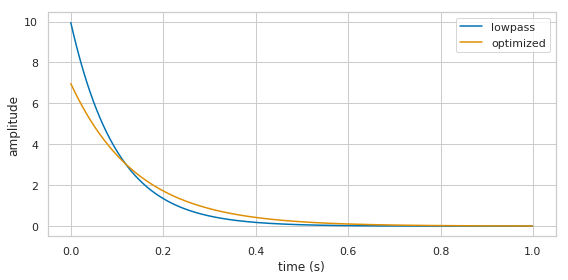

nonzero supv 100
nonzero fb 74


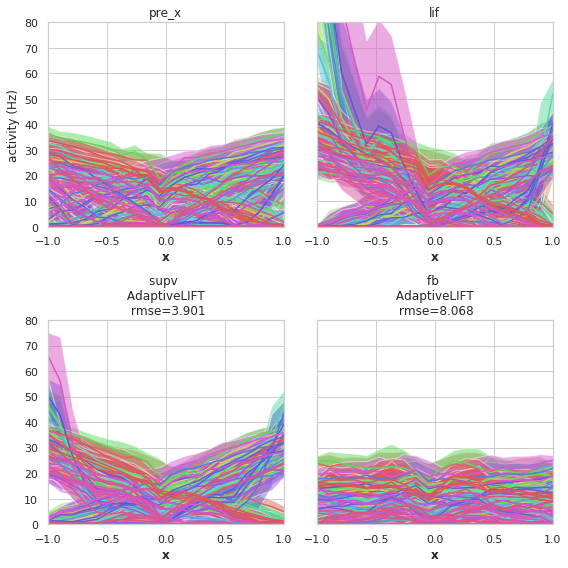

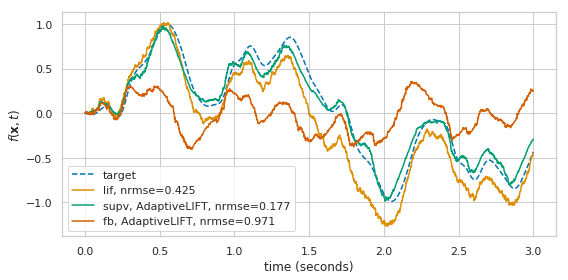

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 100
nonzero fb 100


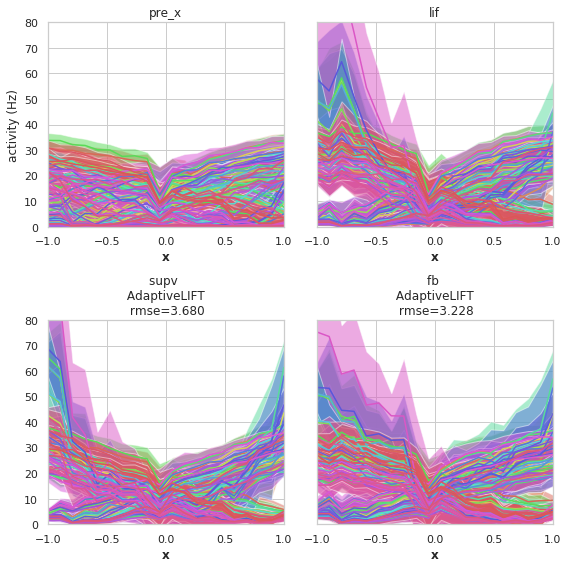

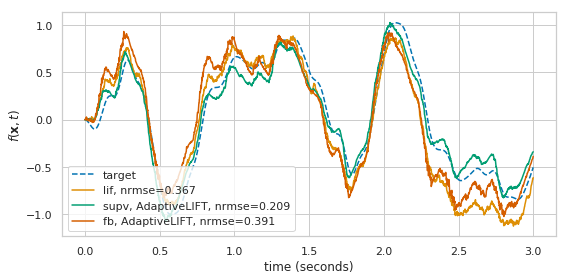

In [61]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 4, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

In [ ]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=AdaptiveLIFT(tau_adapt=0.1, inc_adapt=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 4, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=2,
    n_samples=10000,
    mean_taus=[0.15, 0.01],
    std_taus=[0.01, 0.001],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

## Wilson

oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 4000. -4000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 100:  [0.16778956]


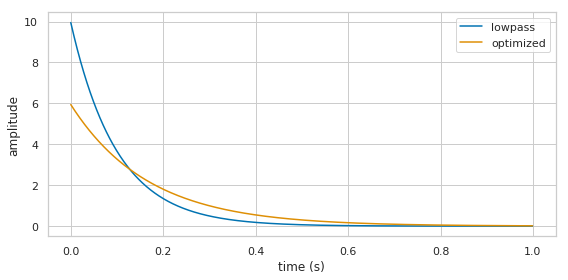

nonzero supv 100
nonzero fb 65


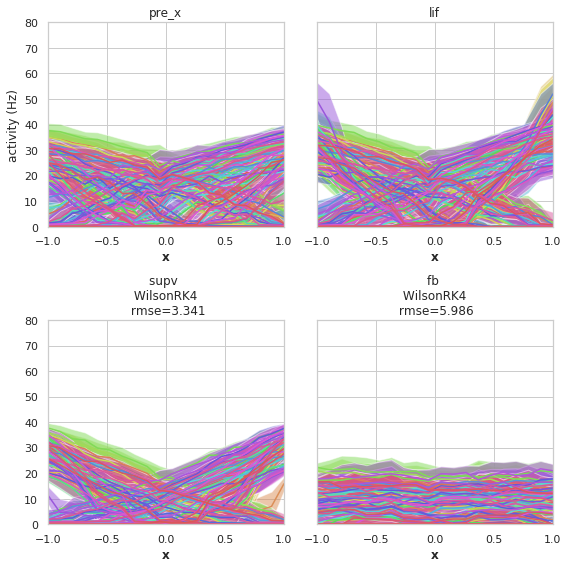

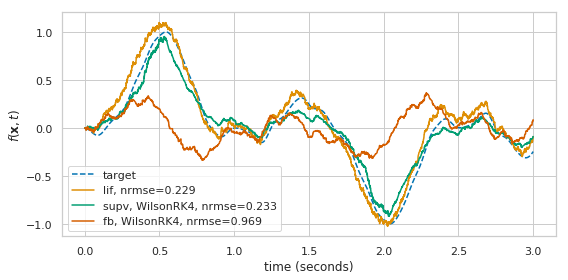

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 99
nonzero fb 99


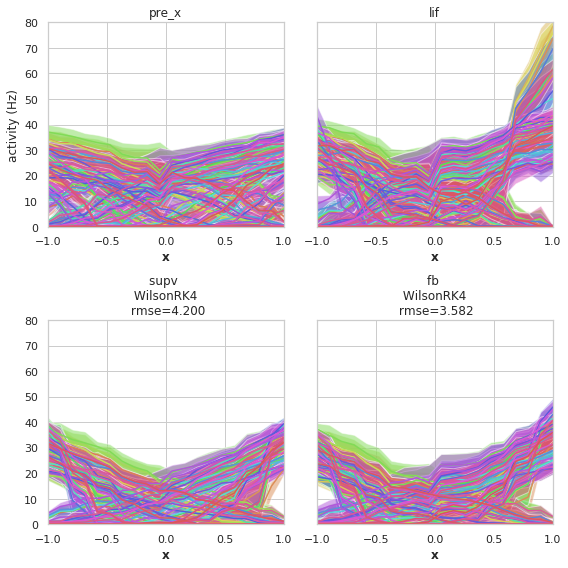

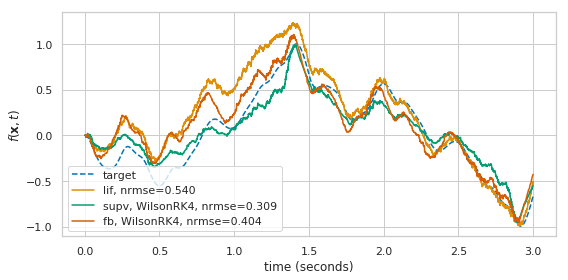

In [63]:
kwargs = dict(
    t=3,
    dt=0.00025,
    dt_sample=0.00025,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=WilsonRK4(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

In [ ]:
kwargs = dict(
    t=3,
    dt=0.00025,
    dt_sample=0.00025,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=WilsonRK4(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=2,
    n_samples=10000,
    mean_taus=[0.1,  0.01],
    std_taus=[0.01, 0.001],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

## Durstewitz NEURON

	1 
oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 91:  [0.11687637]


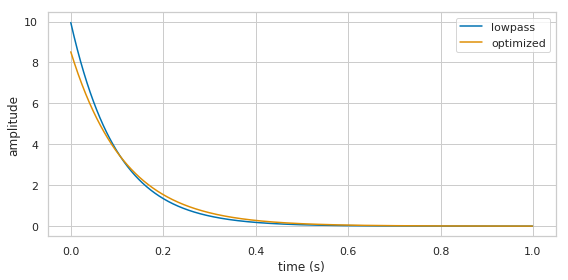

nonzero supv 91
nonzero fb 61


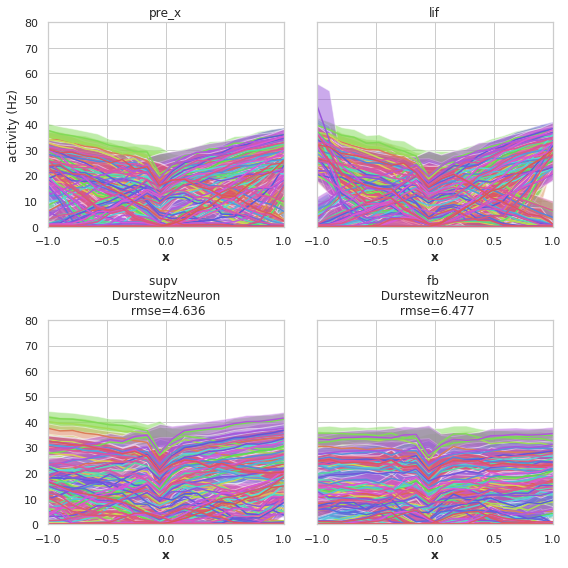

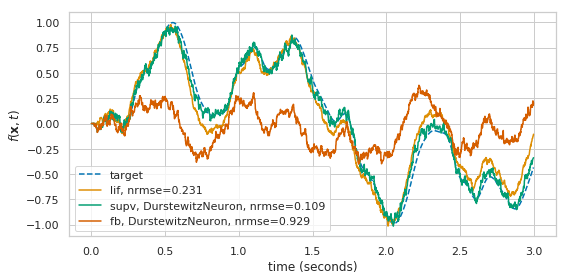

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 100
nonzero fb 100


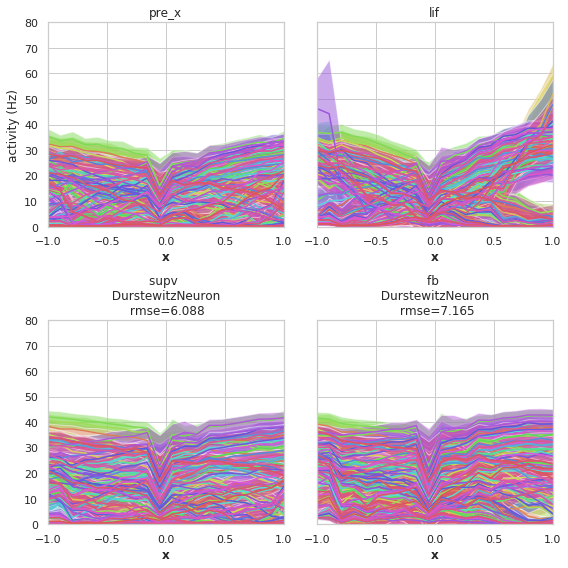

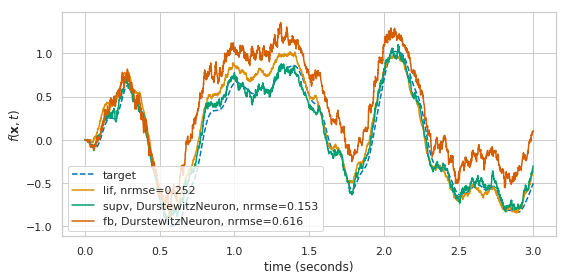

In [39]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=False),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 19:  [0.11606693]


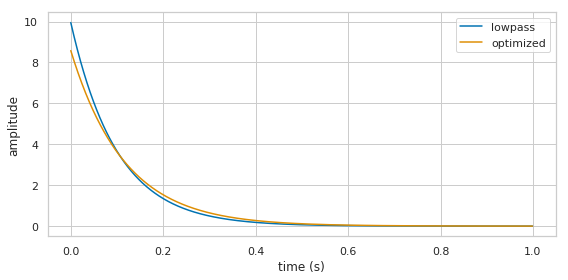

nonzero supv 19
nonzero fb 13


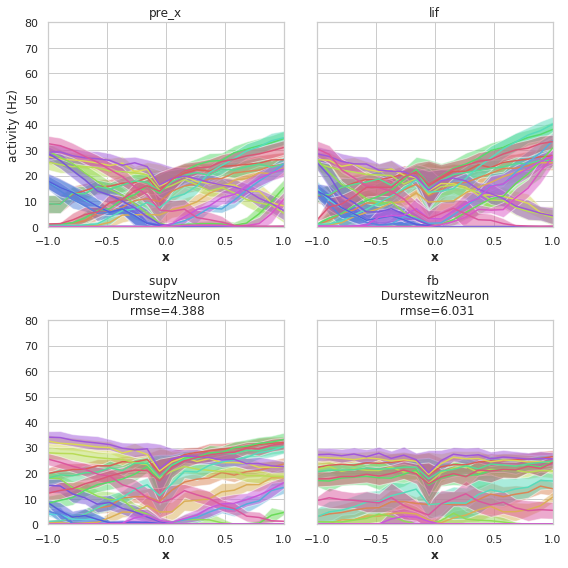

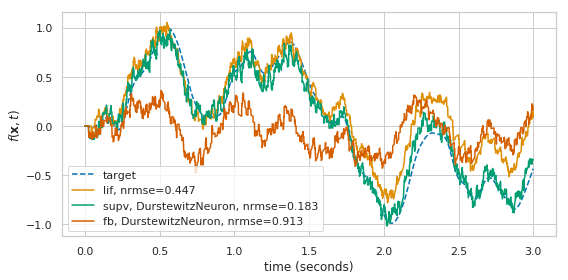

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


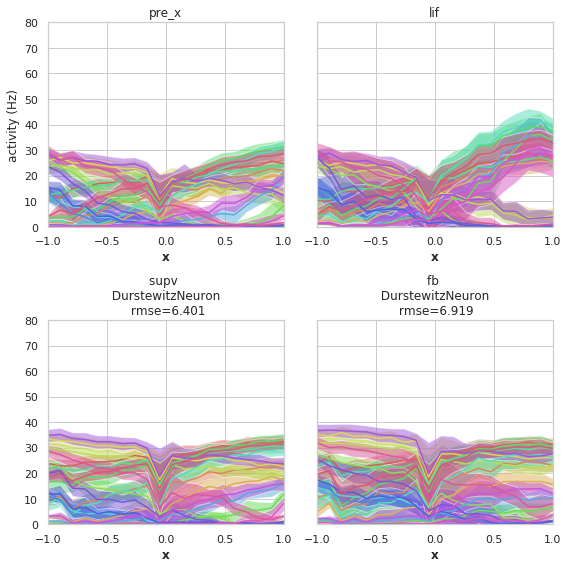

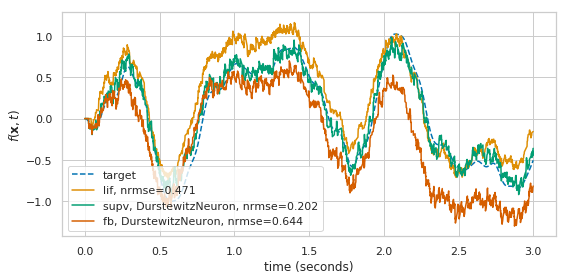

In [35]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=20,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=False),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e0,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 91:  [0.11029441]


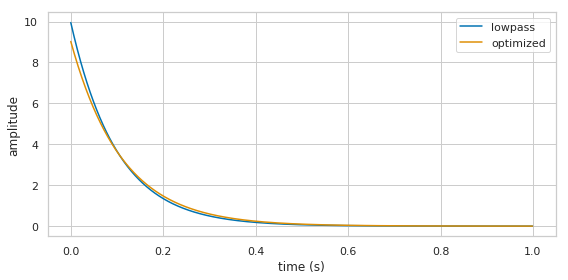

nonzero supv 91
nonzero fb 61


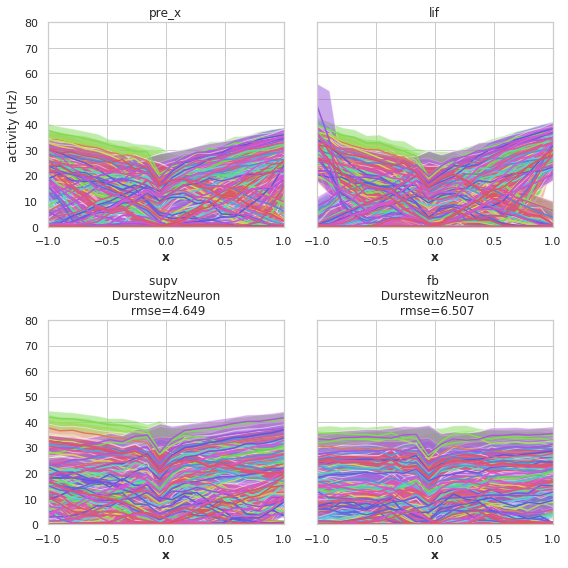

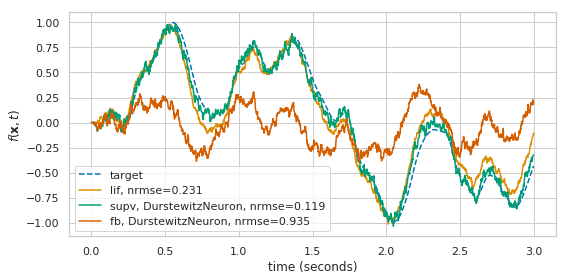

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 100
nonzero fb 100


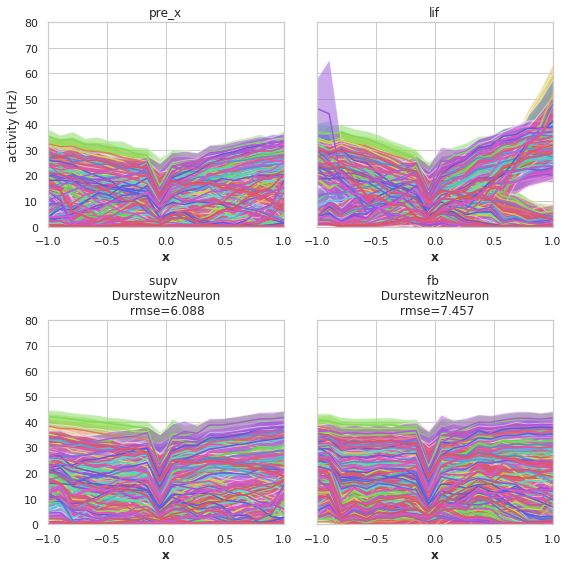

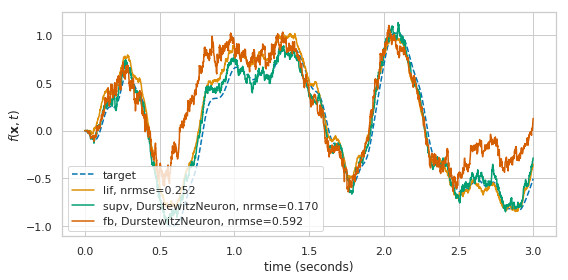

In [67]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=False),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e0,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

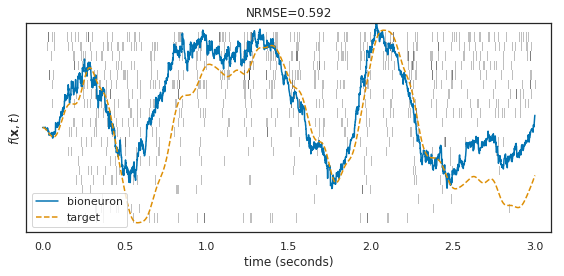

In [70]:
plot_estimate_raster(datadict_fb, d_fb, h, n_spikes=20, **kwargs)

DA=TRUE

In [20]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=True),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=3e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

datadict_supv = run_supv(**kwargs)

	1 


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [ ]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=True),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-2,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

datadict_supv = run_supv(**kwargs)

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 100:  [0.12180477]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 100
nonzero fb 100


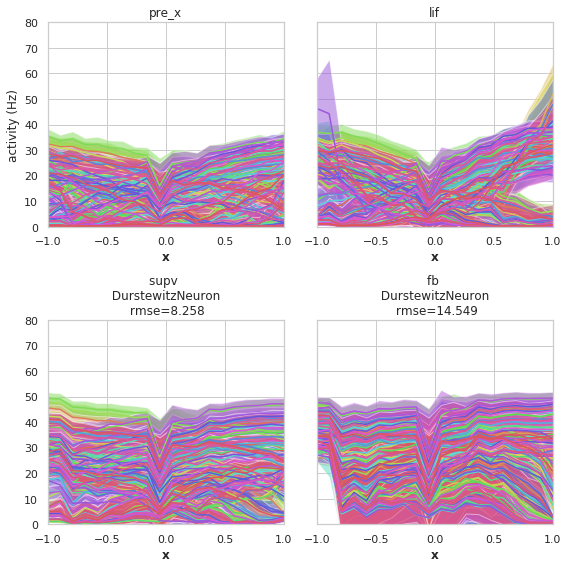

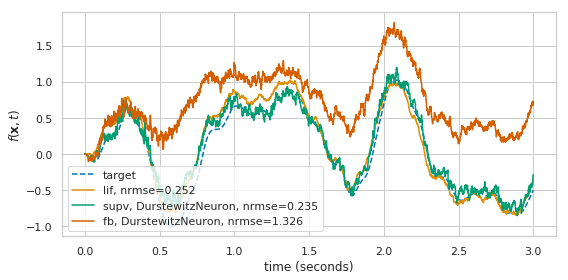

In [21]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['lambda_d'] = 1e-2
kwargs['lambda_c'] = 1e-1
d_fb, h, datadict_fb = run_fb(datadict_supv, **kwargs)

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 100:  [0.11332135]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 100
nonzero fb 100


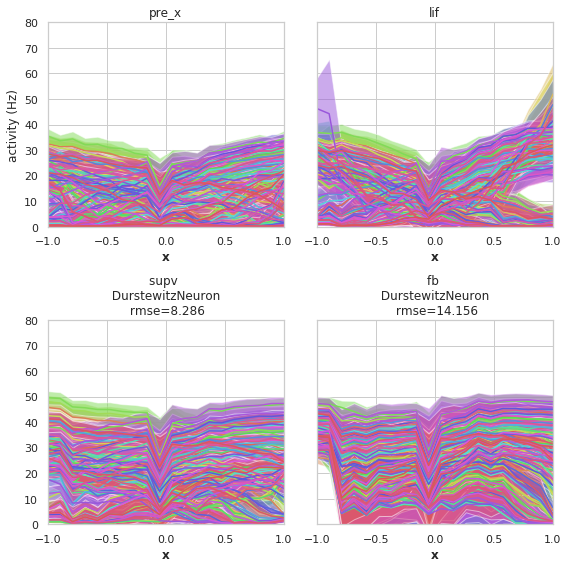

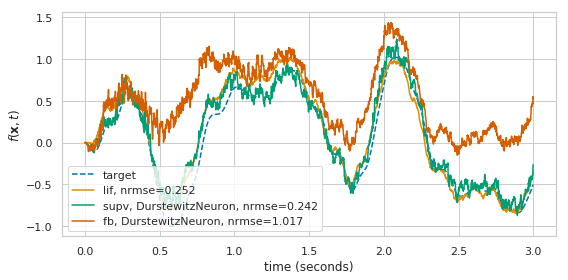

In [22]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['lambda_d'] = 1e-2
kwargs['lambda_c'] = 1e0
d_fb, h, datadict_fb = run_fb(datadict_supv, **kwargs)

In [20]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=20,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=False),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

datadict_supv_noDA = run_supv(**kwargs)

	1 


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 19:  [0.12171898]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


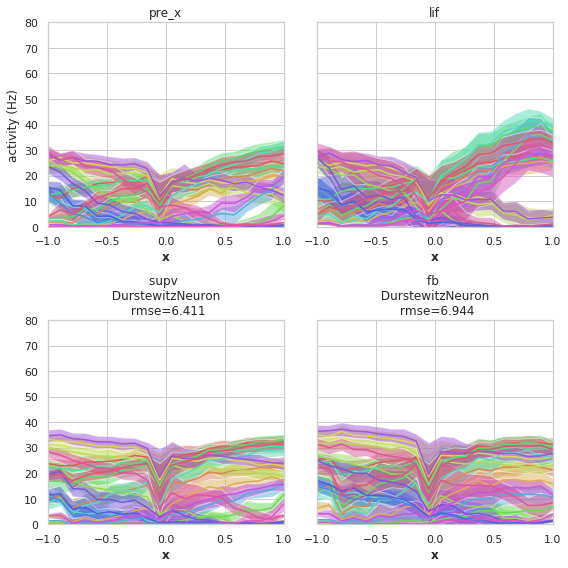

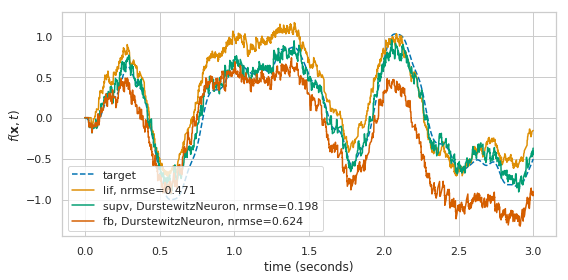

In [22]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['neuron_type'] = DurstewitzNeuron(dt_neuron=0.025, DA=False)
kwargs['lambda_d'] = 1e-1
kwargs['lambda_c'] = 1e-1
d_fb_noDA, h_noDA, datadict_fb_noDA = run_fb(datadict_supv_noDA, **kwargs)

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 19:  [0.12171898]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


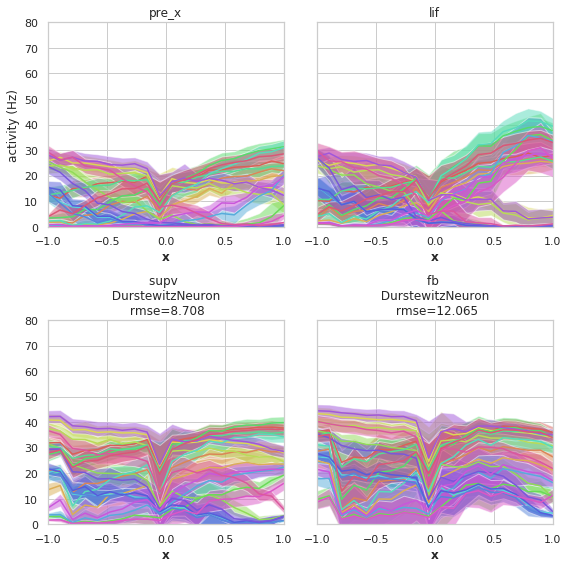

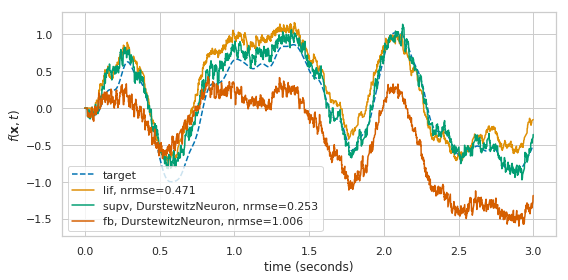

In [25]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['neuron_type'] = DurstewitzNeuron(dt_neuron=0.025, DA=True)
kwargs['lambda_d'] = 1e-1
kwargs['lambda_c'] = 1e-1
d_fb_DA, h_DA, datadict_fb_DA = run_fb(datadict_supv_noDA, **kwargs)

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 19:  [0.12170986]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


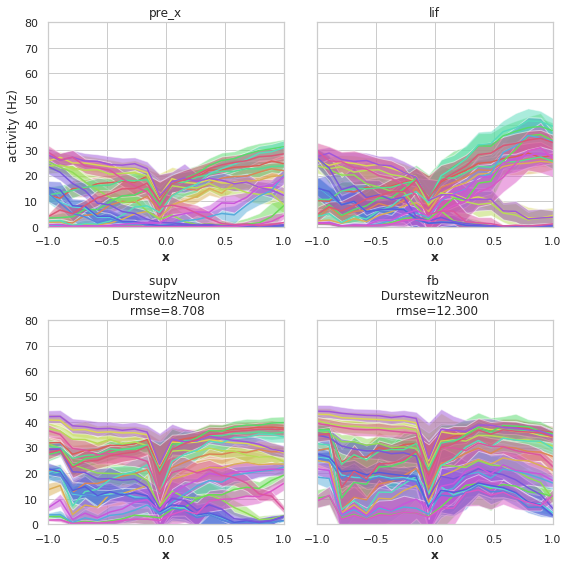

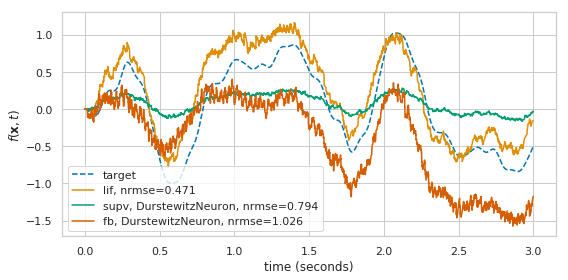

In [26]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['neuron_type'] = DurstewitzNeuron(dt_neuron=0.025, DA=True)
kwargs['lambda_d'] = 1e0
kwargs['lambda_c'] = 1e-1
d_fb_DA, h_DA, datadict_fb_DA = run_fb(datadict_supv_noDA, **kwargs)

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 19:  [0.11606693]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


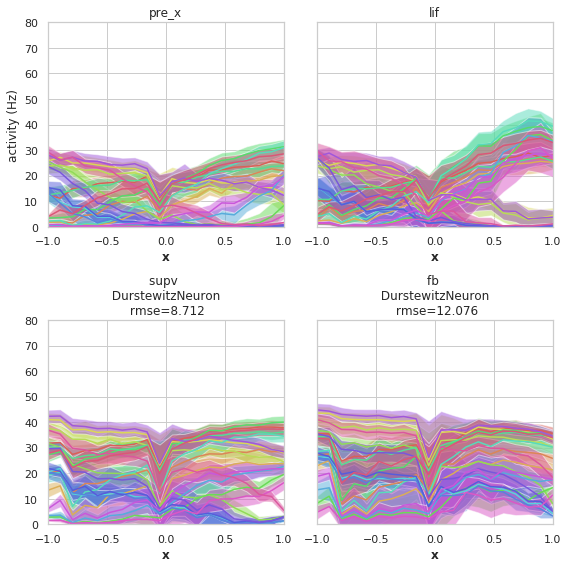

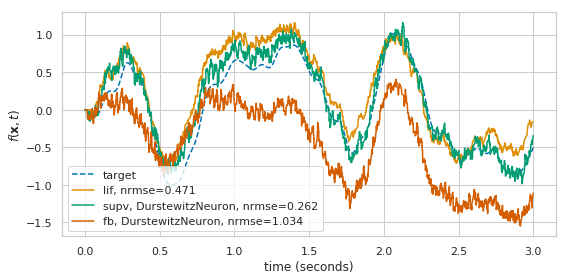

In [27]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['neuron_type'] = DurstewitzNeuron(dt_neuron=0.025, DA=True)
kwargs['lambda_d'] = 1e-1
kwargs['lambda_c'] = 1e0
d_fb_DA, h_DA, datadict_fb_DA = run_fb(datadict_supv_noDA, **kwargs)

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 19:  [0.12232868]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


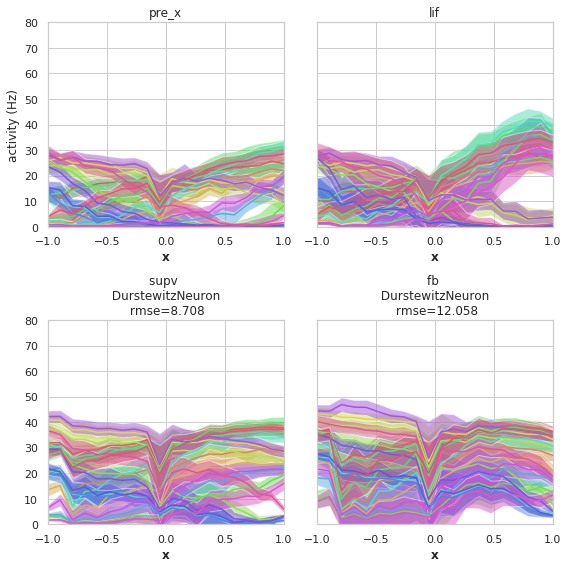

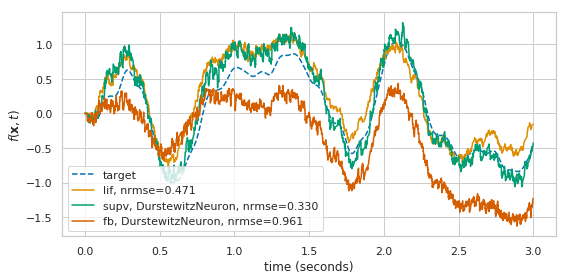

In [28]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['neuron_type'] = DurstewitzNeuron(dt_neuron=0.025, DA=True)
kwargs['lambda_d'] = 3e-2
kwargs['lambda_c'] = 3e-2
d_fb_DA, h_DA, datadict_fb_DA = run_fb(datadict_supv_noDA, **kwargs)

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 19:  [0.12250915]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


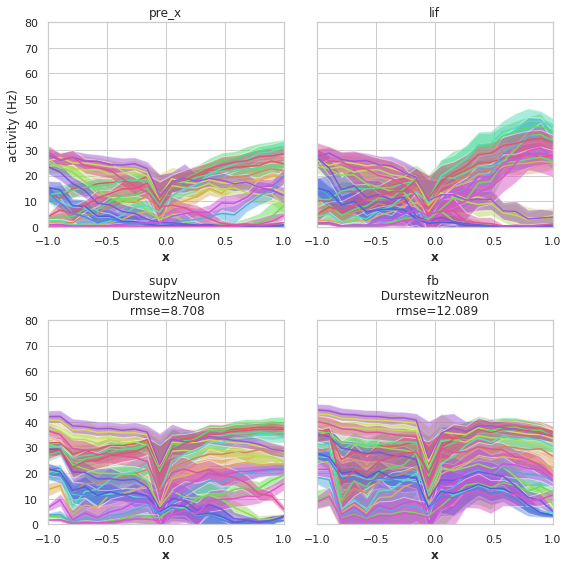

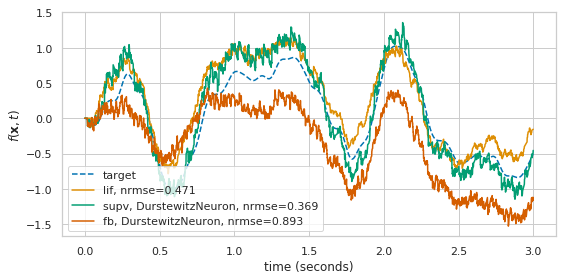

In [29]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['neuron_type'] = DurstewitzNeuron(dt_neuron=0.025, DA=True)
kwargs['lambda_d'] = 1e-2
kwargs['lambda_c'] = 1e-2
d_fb_DA, h_DA, datadict_fb_DA = run_fb(datadict_supv_noDA, **kwargs)

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


taus attempt 0, nonzero d 19:  [0.12250915]
testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


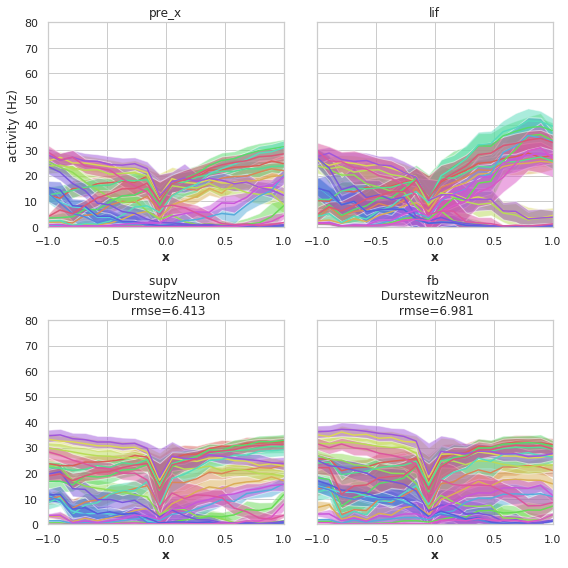

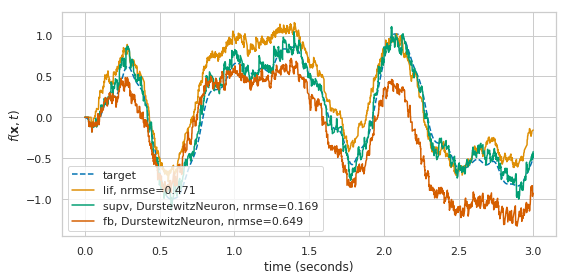

In [30]:
kwargs['seeds'] = {'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5}
kwargs['neuron_type'] = DurstewitzNeuron(dt_neuron=0.025, DA=False)
kwargs['lambda_d'] = 1e-2
kwargs['lambda_c'] = 1e-2
d_fb_DA, h_DA, datadict_fb_DA = run_fb(datadict_supv_noDA, **kwargs)

# Trials

	1 
neuron_type = LIF()
oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 100:  [0.10979474]
testing
trial 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

neuron_type = AdaptiveLIFT()
oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb
taus attempt 0, nonzero d 100:  [0.11577108]
testing
trial 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

neuron_type = WilsonRK4()
oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 4000. -4000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 98:  [0.15070142]
testing
trial 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

neuron_type = DurstewitzNeuron()
oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb
taus attempt 0, nonzero d 82:  [0.10785266]
testing
trial 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


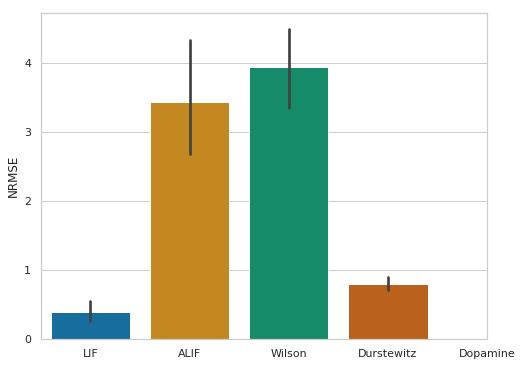

In [20]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

nrmses = run_trials_types(n_trials=10, start=0, **kwargs)

neuron_type = LIF()
oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)
/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 100:  [0.11664032]
testing
trial 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

neuron_type = AdaptiveLIFT()
oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb
taus attempt 0, nonzero d 100:  [0.13445354]
testing
trial 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

neuron_type = WilsonRK4()
oracle method to compute readout decoders for supv


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 4000. -4000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 98:  [0.17475313]
testing
trial 0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

trial 9


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


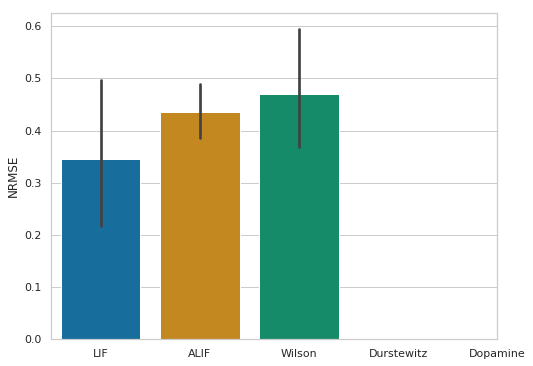

In [64]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

nrmses = run_trials_types(n_trials=10, start=0, **kwargs)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


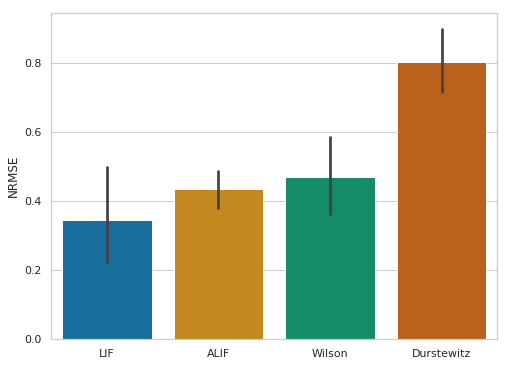

array([[0.27845014, 0.51229801, 0.46338151, 0.85521335],
       [0.88783728, 0.44376518, 0.36180837, 1.10478148],
       [0.26228755, 0.29497994, 0.3968661 , 0.8511033 ],
       [0.14376274, 0.617615  , 0.27529844, 0.54247438],
       [0.42837158, 0.44669046, 0.76155005, 0.77730444],
       [0.16352568, 0.49510414, 0.29670556, 0.96910173],
       [0.28145666, 0.44605669, 0.40304927, 0.71510109],
       [0.25616176, 0.33101447, 0.60126885, 0.72501883],
       [0.60996703, 0.36818511, 0.82138544, 0.81942015],
       [0.14746808, 0.40711827, 0.32534797, 0.68025447]])

In [66]:
plot_read(n_trials=10)

normal gain/bias

oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 20:  [0.13644014]


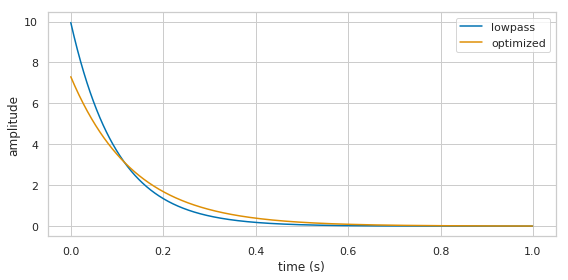

nonzero supv 20
nonzero fb 20


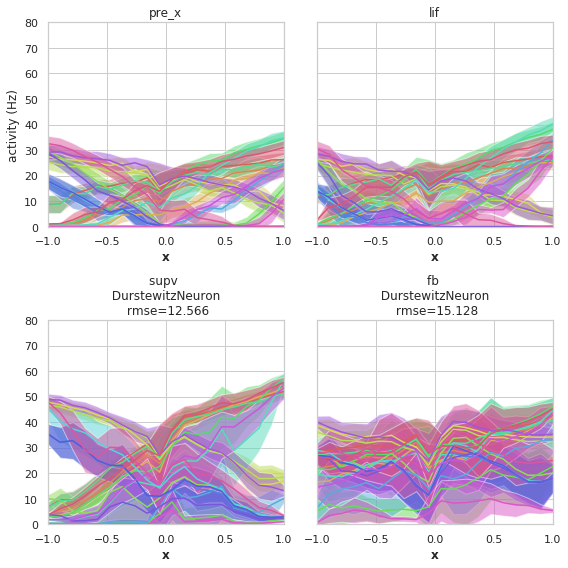

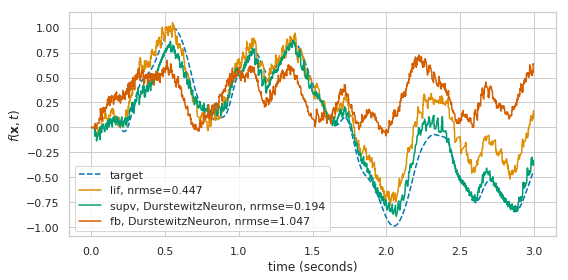

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 20
nonzero fb 20


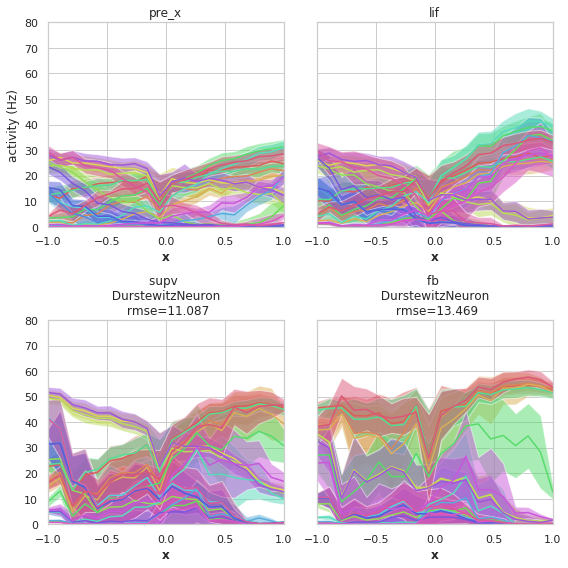

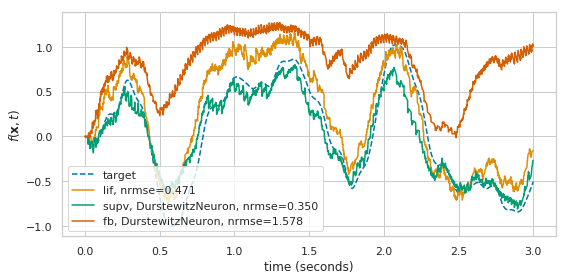

In [32]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=20,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=True),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')

d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

oracle method to compute readout decoders for supv


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

/home/pduggins/nengo/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

least-squares optimization of recurrent filter and decoders for fb


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)


taus attempt 0, nonzero d 95:  [0.13293015]


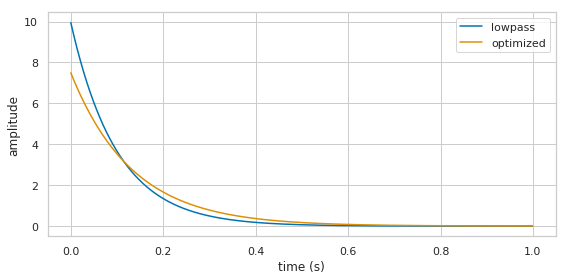

nonzero supv 95
nonzero fb 98


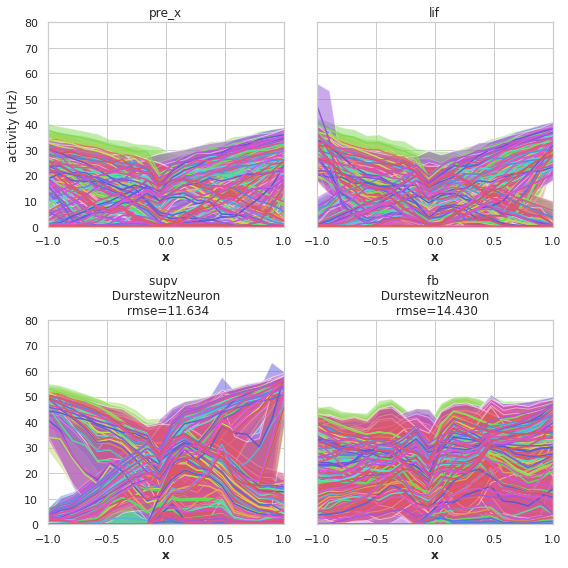

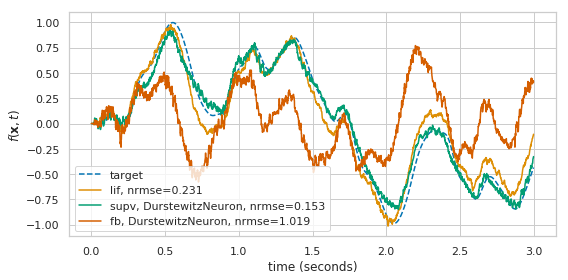

testing (no supervision)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

nonzero supv 99
nonzero fb 91


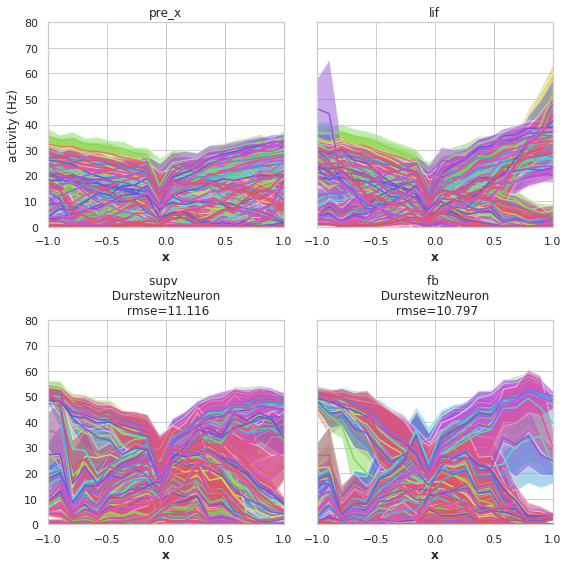

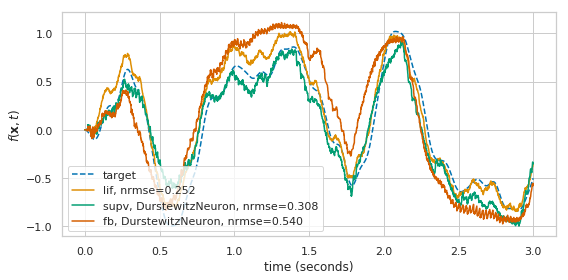

In [33]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=True),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=1,
    n_samples=10000,
    mean_taus=[0.1],
    std_taus=[0.01],
    signal='white_noise')


d_supv, d_fb, h, datadict_supv, datadict_fb = run_once(**kwargs)

In [34]:
np.savez('DA.npz', d_supv=d_supv, d_fb=d_fb, stim=datadict_fb['stim'], tar=datadict_fb['tar'], spk_fb=datadict_fb['spk_fb'])

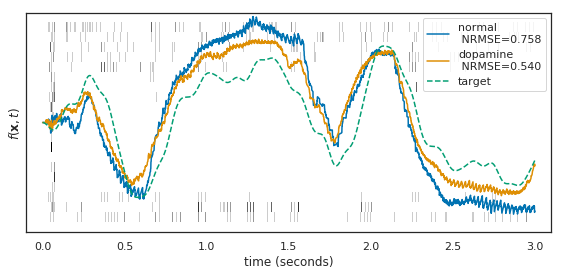

In [62]:
from nengo_extras.plot_spikes import plot_spikes, preprocess_spikes

n_spikes = 20
noDA = np.load('noDA.npz')
d_fb_noDA = noDA['d_fb']
spk_fb_noDA = noDA['spk_fb']
d_fb_DA = d_fb
spk_fb_DA = datadict_fb['spk_fb']
tar = datadict_fb['tar']
dt = kwargs['dt']
dt_sample = kwargs['dt_sample']
n_neurons = kwargs['n_neurons']
taus = kwargs['taus']
lpf = Lowpass(taus['readout'])
A_fb_noDA = h.filt(spk_fb_noDA, dt=dt, y0=0)[::int(dt_sample/dt)]
A_fb_DA = h.filt(spk_fb_DA, dt=dt, y0=0)[::int(dt_sample/dt)]
target = lpf.filt(tar, dt=dt, y0=0)[::int(dt_sample/dt)]
times = dt_sample * np.arange(0, len(target), 1)
xhat_fb_noDA = np.dot(A_fb_noDA, d_fb_noDA)
xhat_fb_DA = np.dot(A_fb_DA, d_fb_DA)
nrmse_fb_noDA = nrmse(xhat_fb_noDA, target=target)
nrmse_fb_DA = nrmse(xhat_fb_DA, target=target)
spk = preprocess_spikes(datadict_fb['trange'], spk_fb_noDA, num=n_spikes)
sns.set(palette='colorblind', style='white')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(times, (n_spikes/2 + 0.75*n_spikes/2*xhat_fb_noDA), label='normal\n NRMSE=%.3f'%nrmse_fb_noDA)
ax.plot(times, (n_spikes/2 + 0.75*n_spikes/2*xhat_fb_DA), label='dopamine\n NRMSE=%.3f'%nrmse_fb_DA)
ax.plot(times, (n_spikes/2 + 0.75*n_spikes/2*target), label='target', linestyle='--')
ax.set(yticks=([]), xlim=((times[0]-0.1, times[-1]+0.1)), xlabel='time (seconds)',
    ylim=((-1, n_spikes+1)), ylabel='$f(\mathbf{x}, t)$')
plot_spikes(spk[0], spk[1], ax=ax)
#     rasterplot(datadict['trange'], datadict['spk_fb'], ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

# plot_estimate_raster(datadict_fb, d_fb, h, **kwargs)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((num=[ 1000. -1000.], den=[1. 0.], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:213: UserWarning: Synapse ((A=[[-0.]], B=[[1.]], C=[[-1000.]], D=[[1000.]], analog=False)) has extra delay due to passthrough (https://github.com/nengo/nengo/issues/938).
  "(https://github.com/nengo/nengo/issues/938)." % sys)
/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted

taus attempt 0, nonzero d 95:  [0.13633715 0.00046851]


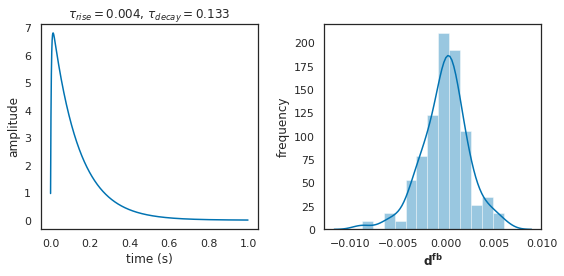

In [82]:
kwargs = dict(
    t=3,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    freq=10,
    amp=1,
    max_rates=Uniform(20, 40),
    intercepts=Default,
    neuron_type=DurstewitzNeuron(dt_neuron=0.025, DA=True),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    lambda_d=1e-1,
    lambda_c=1e-1,
    order=2,
    n_samples=10000,
    mean_taus=[0.18, 0.01],
    std_taus=[0.01, 0.001],
    signal='white_noise')

h2, d_fb2 = update_h(datadict_supv['stim'], datadict_supv['tar'], datadict_supv['spk_supv'], **kwargs)

plot_filter_dist(d_fb, h2, **kwargs)

/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


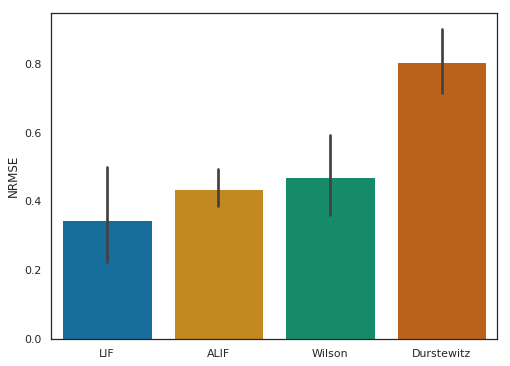

array([[0.27845014, 0.51229801, 0.46338151, 0.85521335],
       [0.88783728, 0.44376518, 0.36180837, 1.10478148],
       [0.26228755, 0.29497994, 0.3968661 , 0.8511033 ],
       [0.14376274, 0.617615  , 0.27529844, 0.54247438],
       [0.42837158, 0.44669046, 0.76155005, 0.77730444],
       [0.16352568, 0.49510414, 0.29670556, 0.96910173],
       [0.28145666, 0.44605669, 0.40304927, 0.71510109],
       [0.25616176, 0.33101447, 0.60126885, 0.72501883],
       [0.60996703, 0.36818511, 0.82138544, 0.81942015],
       [0.14746808, 0.40711827, 0.32534797, 0.68025447]])

In [84]:
plot_read(n_trials=10)